In [1]:
from os.path import join
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import GridSearchCV

In [3]:
DATADIR = join('..', 'data')
MODELDIR = join('..', 'models')
SAMPLES_FILE = 'sampled_states.csv'

def plot_agent_info(sampled_states):
    x_agent = sampled_states.iloc[:, 0]
    y_agent = sampled_states.iloc[:, 1]
    vx_agent = sampled_states.iloc[:, 2]
    vy_agent = sampled_states.iloc[:, 3]

    fig = plt.figure()
    ax = plt.axes()
    ax.scatter(x_agent, y_agent, c='g', s=1)
    ax.scatter(vx_agent, vy_agent, c='r', s=1)
    plt.show()

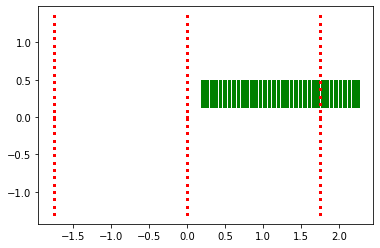

In [6]:
ss = pd.read_csv(join(DATADIR, SAMPLES_FILE))

plot_agent_info(ss)

In [10]:
print(ss['x_agent'].max())
print(ss['y_agent'].max())
print(ss['xdot_agent'].max())
print(ss['ydot_agent'].max())

2.25
0.48273
1.75
1.35


In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ss_norm = scaler.fit_transform(ss)
ss_norm = pd.DataFrame(ss_norm, columns=['x_agent', 'y_agent', 'xdot_agent', 'ydot_agent',
                                         'x_ball', 'y_ball', 'xdot_ball', 'ydot_ball', 'x_opponent',
                                         'y_opponent', 'xdot_opponent', 'ydot_opponent'])            
ss_norm

,x_agent,y_agent,xdot_agent,ydot_agent,x_ball,y_ball,xdot_ball,ydot_ball,x_opponent,y_opponent,xdot_opponent,ydot_opponent
0,0.487805,0.000000,0.5,0.489796,0.499999,0.526794,0.491271,0.563698,0.487805,0.000000,0.5,0.489796
1,0.487805,0.000000,0.5,0.489796,0.499999,0.526794,0.491271,0.563698,0.487805,0.000000,0.5,0.489796
2,0.487805,0.000000,0.5,0.489796,0.499999,0.526794,0.491271,0.563698,0.487805,0.000000,0.5,0.489796
3,0.487805,0.000000,0.5,0.489796,0.499999,0.526794,0.491271,0.563698,0.487805,0.000000,0.5,0.489796
4,0.487805,0.000000,0.5,0.489796,0.499999,0.526794,0.491271,0.563698,0.487805,0.000000,0.5,0.489796
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.373985,0.325579,0.0,0.074074,0.695316,0.406989,0.365195,0.362187,0.000000,0.740540,0.5,0.777778
999996,0.373985,0.205572,0.5,0.037037,0.684121,0.399001,0.365195,0.352472,0.000000,0.807051,0.5,0.740741
999997,0.345527,0.075737,0.0,0.000000,0.672925,0.389295,0.365195,0.342757,0.000000,0.863763,0.5,0.703704
999998,0.317073,0.000000,0.0,0.489796,0.661729,0.377866,0.365195,0.333043,0.000000,0.910648,0.5,0.666667


In [20]:
mbkm_model = MiniBatchKMeans(n_clusters=10_000, random_state=0, batch_size=2048, verbose=True)
mbkm_model.fit(ss_norm)  # 1M samples, around 5m 30s with current setup

Init 1/3 with method k-means++
Inertia for init 1/3: 437.08155425814505
Init 2/3 with method k-means++
Inertia for init 2/3: 441.0359069642592
Init 3/3 with method k-means++
Inertia for init 3/3: 443.301436107281
[MiniBatchKMeans] Reassigning 1024 cluster centers.
Minibatch step 1/48828: mean batch inertia: 0.0145860521277242
[MiniBatchKMeans] Reassigning 1024 cluster centers.
Minibatch step 2/48828: mean batch inertia: 0.016042254837847353, ewa inertia: 0.016042254837847353
[MiniBatchKMeans] Reassigning 1024 cluster centers.
Minibatch step 3/48828: mean batch inertia: 0.01624484736549698, ewa inertia: 0.01604308465601079
[MiniBatchKMeans] Reassigning 1024 cluster centers.
Minibatch step 4/48828: mean batch inertia: 0.016405004422982407, ewa inertia: 0.016044567077893885
[MiniBatchKMeans] Reassigning 1024 cluster centers.
Minibatch step 5/48828: mean batch inertia: 0.017112480392885977, ewa inertia: 0.01604894124645792
[MiniBatchKMeans] Reassigning 1024 cluster centers.
Minibatch step 

MiniBatchKMeans(batch_size=2048, n_clusters=10000, random_state=0, verbose=True)

In [22]:
mbkm_model.inertia_

11277.273424296607

In [26]:
from numpy import savetxt

head = 'x_agent,y_agent,xdot_agent,ydot_agent,' \
        'x_ball,y_ball,xdot_ball,ydot_ball,' \
        'x_opponent,y_opponent,xdot_opponent,ydot_opponent'
        
savetxt(fname=join(DATADIR, 'centroids_10K.csv'),
        X=mbkm_model.cluster_centers_,
        fmt='%.5f',
        delimiter=',',
        header=head,
        comments='')